In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)

def add_time_features(df, time_column):
    '''
        This function will add some time feature based on the param 'time_columns'

        Params:
            df-> Dataframe with the column contained in 'time_column'
            time_column -> the column that is a datetime object

        Returns:
            A dataframe with time features
    '''

    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week
    df['year'] = df[time_column].dt.year
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    return df

def plot_targets(targets):
    '''
        Plot the target, by a giving date

        Params:
            Targets-> A dataframe with the target value
            Start_date -> the start date
            End_date -> the end date

        Returns:
            Sto cazzo
    '''
    plt.figure(figsize=(15, 6))
    plt.plot(targets, label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def to_datetime(df,column):
    '''
        Make the column in datetime format
    '''
    return pd.to_datetime(df[column])

def resampling(df,column):
    '''
        Resample df to 1 hour using mean() as aggregator and drop rows where all columns are NaN

        Params :
            df -> the dataframe to be resampled
            column -> the time column
    '''
    return df.set_index(keys = column).resample('1H').mean().dropna(how='all').reset_index()

def filter_df(df,columnlist):
    return df.drop(columns = columnlist)

def extract_data_calc(df):
    '''
    This function create a dataframe with 'date_forecast' as index and the column 'date_calc' resampled by '1H'.
    If there's no data in a specific bin, the resulting value for that bin would be NaN (not a number).
    Params:
        df -> dataframe with 'date_forecast' and 'date_calc' columns.
            'date_calc' is expected to contain data that the user wants to resample or analyze.
    Returns:
        A dataframe with 'date_calc' resampled.
    '''
    return df.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()



def is_estimated_feature(df):
    '''
        This function will create some time feature and estimated information. It's need to let the model understand is
        estimated value.
        Params:
            df -> It MUST be an estimated dataframe, that contains 'data_forecast' as datetime type
        Returns:
            A dataframe with  'time_delta' and 'is_estimated'
    '''
    df['time_delta'] = (df['date_calc'] - df['date_forecast']).dt.total_seconds() / 3600
    df['is_estimated'] = 1
    return df

def delete_stationarity(df):
    '''
    Removes constant stretches of data within a DataFrame where the 'pv_measurement' column does not change.
    The function identifies blocks of data where the 'pv_measurement' stays constant for more than two consecutive
    points and removes these blocks to address data stationarity.

    params:
        df -> DataFrame
              A pandas DataFrame with a 'pv_measurement' column which contains the data from which to remove stationarity.

    return:
        The DataFrame with constant stretches of data removed from the 'pv_measurement' column.
    '''

    #Calculate the difference, this need for check the constant
    df['diff'] = df['pv_measurement'].diff().fillna(0)

    # Create an indicator for constant stretches
    df['constant'] = (df['diff'] == 0).astype(int)

    # Use the indicator to mark stretches. The diff() function here identifies change-points.
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = df.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than N consecutive time points (in this case 2)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Remove the constant
    filtered_df = df[~df['block'].isin(constant_blocks)]

    return filtered_df.drop(columns=['diff', 'constant', 'block'])


def impute_nan(df):
    '''
        This function will impute the Nan in the give dataframe

        Params:
            df -> the dataframe to be imputed
        Return:
            The dataframe imputed
    '''

    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    return df

import pandas as pd
from scipy import stats

def remove_outliers(df, column, method='IQR', **kwargs):
    '''
    Removes outliers from a specific column in a pandas DataFrame based on the selected method.
    Additionally, prints the number of outliers removed.

    Parameters:
    df : DataFrame
        The pandas DataFrame from which to remove outliers.
    column : str
        The name of the column from which to remove outliers.
    method : str, optional
        The method used to identify and remove outliers. Accepted values are 'IQR' for Interquartile Range or
        'Z-score'. The default is 'IQR'.
    **kwargs : additional keyword arguments
        Additional parameters required for the specified outlier removal method.

    Returns:
    DataFrame
        A new DataFrame with outliers removed from the specified column.
    '''

    if method == 'IQR':
        # Calculate the IQR (Interquartile Range) for the column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Determine upper and lower bounds for outlier detection
        lower_bound = Q1 - (3 * IQR)
        upper_bound = Q3 + (3 * IQR)

        # Filtering before removing to determine the number of outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        non_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    elif method == 'Z-score':
        # Calculate Z-scores for the column
        z_scores = stats.zscore(df[column].dropna())

        # Define a threshold for identifying outliers
        threshold = kwargs.get('threshold', 3) # Default threshold is 3

        # Create masks for outliers and non-outliers
        mask = (abs(z_scores) < threshold)
        non_outliers = df[mask]
        outliers = df[~mask]

    else:
        raise ValueError("Method not recognized. Use 'IQR' or 'Z-score'.")

    # Print the number of outliers removed
    num_outliers = len(outliers)
    #if(num_outliers > 0):
       # print(f'For {column} there was outliers {num_outliers}')

    # Return the DataFrame without outliers
    return non_outliers

# Example usage:
# Assuming `data` is your DataFrame and you want to remove outliers from the 'price' column using IQR method:
# cleaned_data = remove_outliers(data, 'price', method='IQR')

# Or using Z-score method with a specific threshold:
# cleaned_data = remove_outliers(data, 'price', method='Z-score', threshold=2.5)


def one_hot_encoding(df, columns_to_encode):
    '''
        Perform one-hot encoding on the selected columns
        Params:
            df: Dataframe
            columns_to_encode: List of columns
        Return
            Dataframe with columns encoded
    '''
    one_hot_encoded_df = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode)
    return pd.concat([df, one_hot_encoded_df], axis=1)

def should_process_column(column_name):
    """
    Check if the column should be processed based on its name.

    Args:
    column_name (str): The name of the column to check.

    Returns:
    bool: True if the column should be processed, False otherwise.
    """
    excluded_substrings = ['idx', 'time', 'estimated']
    return not any(substring in column_name for substring in excluded_substrings)

def fix_encoding(df):
    df[['dew_or_rime:idx_-1.0', 'dew_or_rime:idx_-0.75', 'dew_or_rime:idx_-0.5', 'dew_or_rime:idx_-0.25', 'dew_or_rime:idx_0.75','is_estimated_0']] = 0
    return df

def preprocessing(targets, observed, estimated, test):
    '''
        This function makes all the preprocessing needed for the correct run of the model, it will perform:
            - Resampling
            - Filtering
            - Imputation
            - Outliers removal
            - Categorical Encoding

        Params:
            targets -> dataframe of the target parquet
            observed -> dataframe of observed train data
            estimated -> dataframe of estimated train data
            test -> dataframe of test data
        Returns:
            train_data -> dataframe of all data ready to train
            test_data -> dataframe of all data ready to test
            is_day -> dataframe of is_day categorical feature for post processing

    '''
    targets['time'] = to_datetime(targets,'time')
    estimated['date_forecast'] = to_datetime(estimated,'date_forecast')
    observed['date_forecast'] = to_datetime(observed,'date_forecast')
    test['date_forecast'] = to_datetime(test,'date_forecast')

    observed_resampled = resampling(observed,'date_forecast')
    estimated_resampled = resampling(estimated,'date_forecast')
    test_resampled = resampling(test,'date_forecast')

    date_calc_resampled_observed = extract_data_calc(estimated)
    date_calc_resampled_test = extract_data_calc(test)

    estimated_resampled = estimated_resampled.merge(date_calc_resampled_observed, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_test, left_on='date_forecast', right_index=True)

    is_day = test_resampled[['date_forecast', 'is_day:idx']]
    test_resampled = filter_df(test_resampled,['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = filter_df(observed_resampled,['is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = filter_df(estimated_resampled,[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])

    #This MUST be zero because is not estimated.
    observed_resampled['is_estimated'] = 0
    observed_resampled['time_delta'] = 0

    estimated_resampled = is_estimated_feature(estimated_resampled)
    test_resampled = is_estimated_feature(test_resampled)

    X = pd.concat([observed_resampled,estimated_resampled],axis = 0)
    train_data = pd.merge(targets, X, how='inner', left_on='time', right_on='date_forecast')

    train_data = add_time_features(train_data, 'time')
    test_data = add_time_features(test_resampled, 'date_forecast')

    train_data = delete_stationarity(train_data)

    train_data = filter_df(train_data, ['time','date_calc'])
    test_data = filter_df(test_resampled, ['date_calc'])

    train_data = impute_nan(train_data)
    test_data = impute_nan(test_data)
    return train_data, test_data, is_day

In [2]:
from sklearn.model_selection import TimeSeriesSplit
def train_data_split(n_splits = 5):
    '''
        This function return the cross_validator split
    '''
    return TimeSeriesSplit(n_splits=n_splits)

import re
def regexdf(df):
    '''
        This function let lgbm work, this because it cannot accept ':'
    '''
    return df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_-]+', '', x))



def final_model(df,model,param,X_test):
    '''
        This function will retrain on the bagged model so the model is trained on ALL TRAIN DATA.

        Params:
            df -> Train data
            model -> your model
            param -> your hyperparameter
            X_test -> Test Data
        Return:
            the prediction
    '''
    X_train = df.drop(columns = 'pv_measurement')
    y_train = df['pv_measurement']
    model.fit(X_train,y_train)
    return model.predict(X_test)

In [3]:
def post_process(prediction, is_day):
    '''
        This function will post_process the predicition, by multiplying the is_day on that prediction.
        I.E.
            This is for rescale the prediction that can be too high in a 0.5 day moment.
        Params:
            Prediction -> your prediction
            is_day -> the is_day dataframe
        Return:
            the clipped version of the adjusted prediction, it's clipped for any eventual negative prediction
    '''
    adjusted_predictions = prediction * is_day['is_day:idx']
    return np.clip(adjusted_predictions, 0, None)

def submission(predictions):
    '''
        This function will create a ready to deliver file

        Params:
            predictions -> the entire prediction for all the location

        Returns:
            stocazzo
        Save:
            Submission file

    '''
    all_predictions = np.array(predictions).flatten()
    # Save the final_predictions to CSV
    df = pd.DataFrame(all_predictions, columns=['prediction'])
    df['id'] = df.index
    df = df[['id', 'prediction']]
    df.to_csv('TestFECla3.csv', index=False)

def feature_engineering(df):
    '''
        This function will create new feature from the interaction of different feature of df dataframe.

        Params:
            df: dataframe
        Return:
            FE dataframe
    '''

    df['direct_diffuse_rad_interaction'] = df['direct_rad:W'] * df['diffuse_rad:W']
    df['raddir'] = (df['direct_rad:W'] ) * (df['absolute_humidity_2m:gm3'])
    df['effectivehum'] = (df['absolute_humidity_2m:gm3']) * (df['direct_rad:W'])
    df['Radiazione_solare_effettiva'] = (df['direct_rad:W'] + df['diffuse_rad:W'] ) * (df['effective_cloud_cover:p'])
    df['direct_radW_squared'] = df['direct_rad:W'] ** 2
    df['clearcloud'] =   df['clear_sky_rad:W']*df['total_cloud_cover:p']
    df['radiation_squared'] = df['clear_sky_rad:W'] ** 2
    df['effectivehum'] = (df['absolute_humidity_2m:gm3']) * (df['direct_rad:W'])

   # df = df[df.index.month.isin([4, 5, 6, 7, 8, 9])]

    return df

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

def tune_model(X, y, model_params, n_iter=100, cv=2, verbose=1, random_state=42, n_jobs=-1):

    
   # Store the best estimators here
    best_estimators = {}

    # Define a dictionary with model shorthand and actual regressor objects
    models = {
        'rf': RandomForestRegressor(),
        'et': ExtraTreesRegressor(),
        'xgboost': XGBRegressor(),
        'lightgbm': LGBMRegressor(),
        'catboost': CatBoostRegressor(verbose=0, thread_count=n_jobs),

    }
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Loop through the models and perform Randomized Search
    for name, model in models.items():
        if name in model_params:  # Only if model parameters were provided
            print(f"Tuning hyperparameters for {name}...")
            search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=model_params[name],
                    n_iter=n_iter,
                    cv=cv,
                    verbose=verbose,
                    random_state=random_state,
                    scoring=mae_scorer,
                    n_jobs=n_jobs
                )
            search.fit(X, y['pv_measurement'])
            best_estimators[name] = search.best_estimator_
            print(f"Best parameters found for {name}:")
            print(search.best_params_)
        else:
            print(f"No parameters provided for {name}, skipping...")

    return best_estimators


In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

def stacking_ensemble_time_series(models, X, y, meta_learner=ExtraTreesRegressor(), n_folds=5):
    # Create the time series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_folds)

    # To store out-of-fold predictions
    meta_features = np.zeros((y.shape[0], len(models)))

    # Train and generate meta-features
    for idx, (name, model) in enumerate(models.items()):
        print(f"Training base model: {name}")
        oof_predictions = np.zeros(y.shape[0])

        for train_index, test_index in tscv.split(X):
            # Split data into folds
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Clone the model to ensure we have a fresh model
            cloned_model = clone(model)
            cloned_model.fit(X_train, y_train['pv_measurement'])

            # Generate out-of-fold predictions
            oof_predictions[test_index] = cloned_model.predict(X_test)

        # Store out-of-fold predictions as meta-features
        meta_features[:, idx] = oof_predictions

    # Retrieve the last fold for training the meta-learner
    _, meta_train_index = list(tscv.split(X))[-1]
    X_meta_train, y_meta_train = meta_features[meta_train_index, :], y.iloc[meta_train_index]

    # Train the meta-learner on the last fold's meta-features
    print("Training meta-learner...")
    meta_learner.fit(X_meta_train, y_meta_train['pv_measurement'])

    # Fit all the base models on the full training data
    fitted_models = {}
    for name, model in models.items():
        model.fit(X, y['pv_measurement'])
        fitted_models[name] = model

    # Function to make ensemble predictions
    def make_predictions(X_new):
        meta_features_new = np.column_stack([
            fitted_model.predict(X_new) for _, fitted_model in fitted_models.items()
        ])
        return meta_learner.predict(meta_features_new)

    return fitted_models, meta_learner, make_predictions


In [61]:
from scipy.stats import randint, uniform

# Parameters for Random Forest
rf_params = {
    'n_estimators': randint(100, 500),  # The number of trees in the forest.
    'max_depth': randint(3, 20),  # The maximum depth of the trees.
    'min_samples_split': uniform(0.01, 0.1),  # The minimum number of samples required to split an internal node.
    'min_samples_leaf': uniform(0.01, 0.1),  # The minimum number of samples required to be at a leaf node.
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}

# Parameters for Extra Trees
et_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': uniform(0.01, 0.1),
    'min_samples_leaf': uniform(0.01, 0.1),
    'bootstrap': [True, False]
}

# Parameters for XGBoost
xgb_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),  # Also known as eta, step size shrinkage used to prevent overfitting.
    'subsample': uniform(0.5, 0.5),  # Subsample ratio of the training instances.
    'colsample_bytree': uniform(0.5, 0.5),  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child.
}

# Parameters for LightGBM
lgbm_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(-1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 300),  # Number of leaves in full tree.
    'min_child_samples': randint(10, 100),  # Minimum number of data needed in a child (leaf).
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'verbose' : [-1],
    
}

# Parameters for CatBoost
cat_params = {
    'iterations': randint(100, 500),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': randint(1, 10),  # Coefficient at the L2 regularization term of the cost function.
    'border_count': randint(1, 255),  # The number of splits for numerical features.
    'subsample': uniform(0.5, 0.5),
}


# Combine all parameter dictionaries into one
model_params = {
    'rf': rf_params,
    'et': et_params,
    'xgboost': xgb_params,
    'lightgbm': lgbm_params,
    'catboost': cat_params
}

In [95]:
import json
models = {

        'xgboost': XGBRegressor(),
        'lightgbm': LGBMRegressor(),
        'catboost': CatBoostRegressor(verbose=0, thread_count=-1),
        'rf': RandomForestRegressor(),
        'et': ExtraTreesRegressor(),
    }
locations = ['A','B','C']
all_predictions = []

for loc in locations:
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    train_data, test_data, is_day= preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)
    train_data = regexdf(train_data)
    test_data = regexdf(test_data)
    test_data = test_data[train_data.drop(columns='pv_measurement').columns]
    test_data = test_data.drop(columns = 'date_forecast')

    X = train_data.drop(columns = ['pv_measurement','date_forecast']).reset_index().drop(columns = 'index')
    y = train_data['pv_measurement'].reset_index().drop(columns = 'index')
    print(X.shape)
    print('__________')

    best_models = tune_model(X, y, model_params, n_iter=50)
    with open(f'best_params{loc}.json', 'w') as f:
            json.dump({name: model.get_params() for name, model in best_models.items()}, f)
    print('__________')
    fitted_models, meta_learner, make_predictions = stacking_ensemble_time_series( best_models, X, y)
    predictions = make_predictions(test_data)
    predictions_fix = post_process(predictions.flatten(),is_day)
    all_predictions.append(predictions_fix)

(19622, 60)
__________
Tuning hyperparameters for rf...
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters found for rf:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 0.02375209441459933, 'min_samples_split': 0.044106635105025854, 'n_estimators': 250}
Tuning hyperparameters for et...
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters found for et:
{'bootstrap': False, 'max_depth': 18, 'min_samples_leaf': 0.014077514155476391, 'min_samples_split': 0.06908929431882418, 'n_estimators': 445}
Tuning hyperparameters for xgboost...
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters found for xgboost:
{'colsample_bytree': 0.5932592551999272, 'learning_rate': 0.022232542466429174, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 445, 'subsample': 0.7560465291496405}
Tuning hyperparameters for lightgbm...
Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters found for lightgb

In [67]:
y

,pv_measurement
0,19.36
1,251.02
2,263.78
3,522.72
4,904.42
...,...
19617,907.72
19618,692.56
19619,194.70
19620,9.02


In [10]:
import json

def save(best_models, loc):
  best_params = {}

  # Leggere il file esistente se esiste e caricare i parametri
  filename = f'best_params{loc}.json'
  try:
      with open(filename, 'r') as file:
          best_params = json.load(file)
  except FileNotFoundError:
      print(f"Il file '{filename}' non esiste. Sarà creato uno nuovo.")

  # Iterazione attraverso ciascun modello nel dizionario best_models
  for model_name, model in best_models.items():
      if model_name in ['rf', 'et']:  # Scikit-learn models
          best_params[model_name] = model.get_params()
      elif model_name == 'xgboost':
          best_params[model_name] = model.get_xgb_params()
      elif model_name == 'lightgbm':
          best_params[model_name] = model.get_params()
      elif model_name == 'catboost':
          best_params[model_name] = model.get_params()

  # Salvare il dizionario aggiornato nel file
  with open(filename, 'w') as file:
      json.dump(best_params, file, indent=4)

  print(f"I parametri dei modelli sono stati salvati o aggiornati in '{filename}'")


In [96]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('TestFE+Ens.csv', index=False)

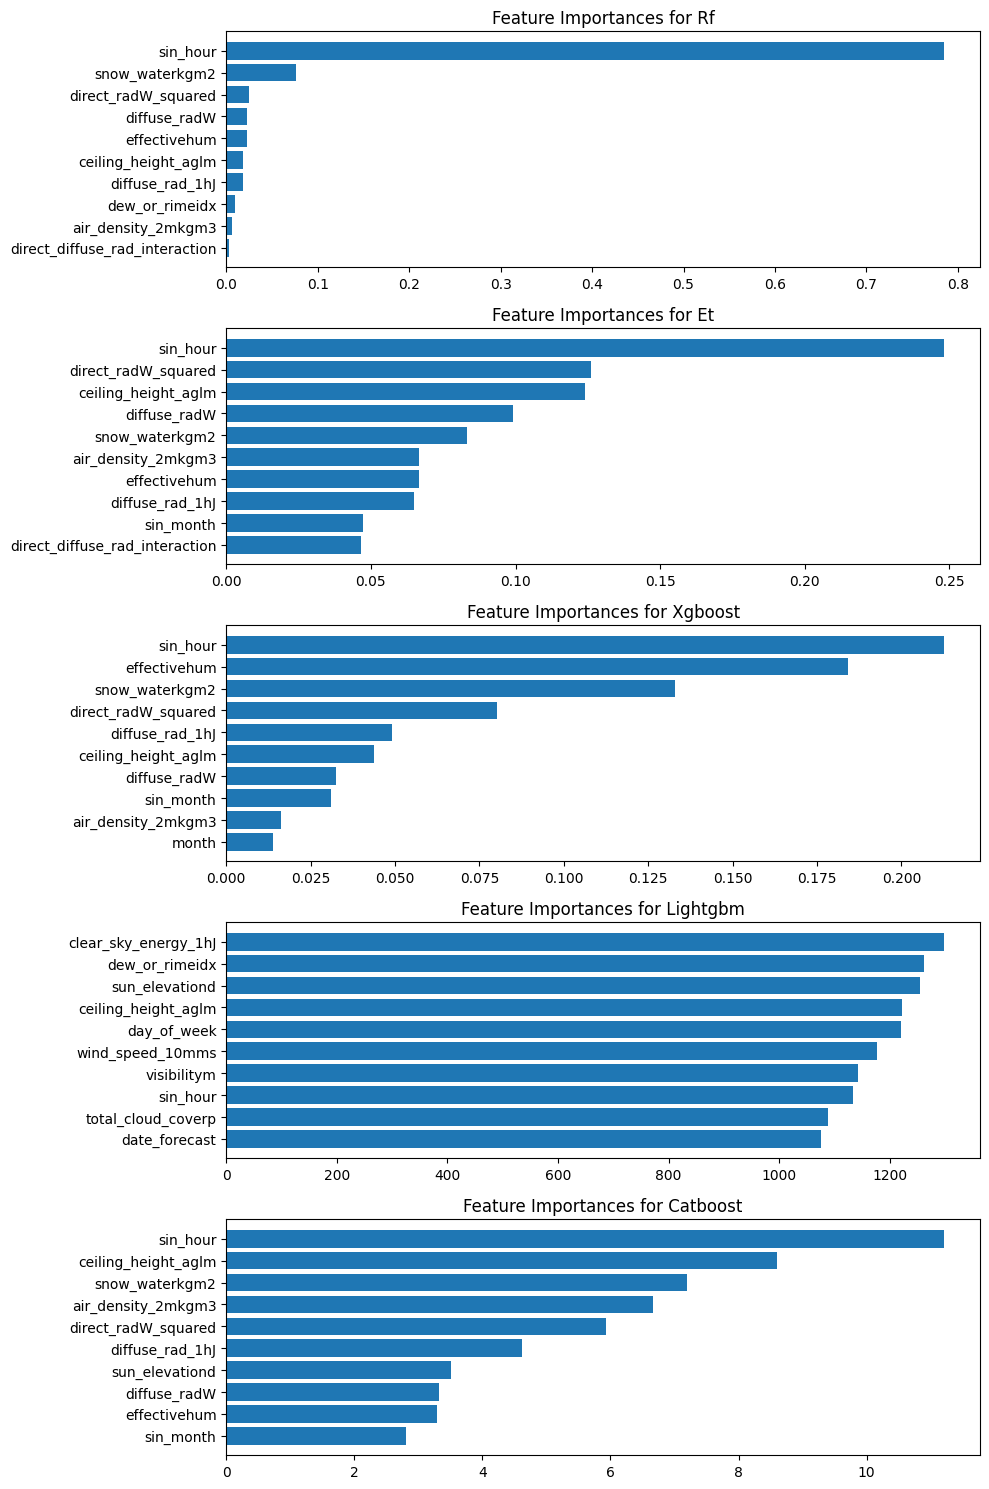

In [100]:
import matplotlib.pyplot as plt

# Assumiamo che best_estimators sia un dizionario del tipo:
# best_estimators = {
#     'lightgbm': trained_lightgbm_model,
#     'catboost': trained_catboost_model,
#     'xgboost': trained_xgboost_model,
#     'rf': trained_rf_model,
#     'et': trained_et_model
# }

# Numero di feature più importanti da visualizzare
top_n_features = 10

# Creiamo una figura con subplots
fig, axes = plt.subplots(nrows=len(best_models), ncols=1, figsize=(10, 15))

# Iteriamo su ogni modello e tracciamo le feature importance
for ax, (model_name, model) in zip(axes, best_models.items()):
    # Otteniamo le feature importance e i nomi delle feature
    # Per alcuni modelli, potresti dover adattare la modalità di estrazione delle feature importance
    importances = model.feature_importances_
    # Assumiamo che abbiamo una lista dei nomi delle feature
    feature_names = train_data.columns
    indices = np.argsort(importances)[-top_n_features:]

    # Tracciamo le feature importance
    ax.barh(range(len(indices)), importances[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_title(f'Feature Importances for {model_name.capitalize()}')

# Regoliamo automaticamente lo spazio tra i subplots per evitare sovrapposizioni
plt.tight_layout()
plt.show()


<Axes: >

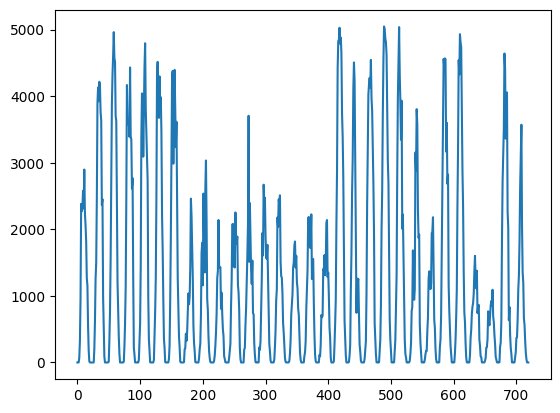

In [98]:
df['prediction'][0:720].plot()